# Analysis of the Mental Health in the Tech Industry

This project purpose is to analyse the Mental Health in the Tech Industry Dataset. 
We want to explore and find how often mental health disorders are met among the  tech workplace and test few hypothesis. 

Thus, we will clean and prepare data, then run EDA on these questions:
1. On which years surveys were conducted?
2. What was the surveys respondents sample size?
3. What are the surveys gender composition?
4. What are the surveys age composition?
5. What is the geographical respondents distribution?
6. How often mental heath disorder (MHD) is met among the tech workplace?
7. What conditions of MHD are most often met?
8. Are there any differences per gender of having MHD?
9. Are there certain age groups where MHD are met more often?
10. H0: The more employees organization has the more MHD cases could be meet.
11. H0: People with MHD working at companies, which have benefits for mental health support, experience less work interfence and is more productive.
12. H0: Over time confidence to share about MHD is changing, people became more open.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import os
import itertools

In [2]:
os.getcwd()

'/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2S1'

## Data loading

Let's load the database and check what tables SQLite file has inside:

In [3]:
input_path = "/Users/kristinazekiene/Documents/LearningPython/TuringCollege/M2S1/Input/mental_health.sqlite"
con = sqlite3.connect(input_path)

table = pd.read_sql('''
            SELECT * FROM sqlite_master 
            WHERE TYPE = 'table'; ''',con)
table

,type,name,tbl_name,rootpage,sql
0,table,Answer,Answer,2,"CREATE TABLE ""Answer"" (\n\t""AnswerText"" VARCHA..."
1,table,Question,Question,1434,"CREATE TABLE ""Question"" (\n\t""questiontext"" VA..."
2,table,Survey,Survey,1438,"CREATE TABLE ""Survey"" (\n\t""SurveyID"" INTEGER ..."


We will check what columns and data types has each table

In [4]:
for row in table["sql"]:
    print(row)

CREATE TABLE "Answer" (
	"AnswerText" VARCHAR(10000) NULL,
	"SurveyID" INTEGER NULL,
	"UserID" INTEGER NULL,
	"QuestionID" INTEGER NULL
)
CREATE TABLE "Question" (
	"questiontext" VARCHAR(1000) NULL,
	"questionid" INTEGER NULL
)
CREATE TABLE "Survey" (
	"SurveyID" INTEGER NOT NULL,
	"Description" VARCHAR(255) NULL,
	PRIMARY KEY ("SurveyID")
)


We will quere tables and check their first rows:

In [5]:
questions_df = pd.read_sql_query("SELECT * from Question", con)
display(questions_df.head(4))

answers_df = pd.read_sql_query("SELECT * from Answer", con)
display(answers_df.head(4))

surveys_df = pd.read_sql_query("SELECT * from Survey", con)
display(surveys_df.head(4))

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4


,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1


,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018


Let's check how many data and what types are in the datasets

In [6]:
questions_df.info()
print(" ")
answers_df.info()
print(" ")
surveys_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   questiontext  105 non-null    object
 1   questionid    105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236898 entries, 0 to 236897
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   AnswerText  236898 non-null  object
 1   SurveyID    236898 non-null  int64 
 2   UserID      236898 non-null  int64 
 3   QuestionID  236898 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.2+ MB
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   SurveyID     5 non-null      int64 
 1   Description  5 non-null      object
dtyp

## Data cleaning & preparation & overview

### What questions are conducted in the survey?

In [7]:
for index, row in questions_df.iterrows():
    print(row['questionid'], row['questiontext'])

1 What is your age?
2 What is your gender?
3 What country do you live in?
4 If you live in the United States, which state or territory do you live in?
5 Are you self-employed?
6 Do you have a family history of mental illness?
7 Have you ever sought treatment for a mental health disorder from a mental health professional?
8 How many employees does your company or organization have?
9 Is your employer primarily a tech company/organization?
10 Does your employer provide mental health benefits as part of healthcare coverage?
11 Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12 Would you bring up a mental health issue with a potential employer in an interview?
13 Is your primary role within your company related to tech/IT?
14 Do you know the options for mental health care available under your employer-provided health coverage?
15 Has your employer ever formally discussed mental health (for exampl

Looking at the survey questions we have selected the most interesting and relevant questions and answers to load to perform analysis and get information about mental health situation among Tech companies.

We will reshape data set format and prepare it for the analysis that it would suit better our goal.

In [8]:
survey_df = pd.read_sql_query("""WITH qa_info AS (
            SELECT 
                a.*,
                q.questiontext
            FROM Answer AS a
            LEFT JOIN Question AS q
                ON a.QuestionID = q.questionid
            )
            SELECT 
                SurveyID,
                UserID,
                MAX(CASE WHEN QuestionID = 1 THEN AnswerText END) AS Age,
                MAX(CASE WHEN QuestionID = 2 THEN AnswerText END) AS Sex,
                MAX(CASE WHEN QuestionID = 3 THEN AnswerText END) AS CountryLiveIn,
                MAX(CASE WHEN QuestionID = 4 THEN AnswerText END) AS USStateLiveIn,
                MAX(CASE WHEN QuestionID = 5 THEN AnswerText END) AS SelfEmployed,
                MAX(CASE WHEN QuestionID = 6 THEN AnswerText END) AS FamilyHistoryMentalIllness,
                MAX(CASE WHEN QuestionID = 7 THEN AnswerText END) AS TreatmentForMentalHealthDisorder,
                MAX(CASE WHEN QuestionID = 8 THEN AnswerText END) AS EmployeesNumber,
                MAX(CASE WHEN QuestionID = 9 THEN AnswerText END) AS IsTechCompany,
                MAX(CASE WHEN QuestionID = 32 THEN AnswerText END) AS HadMentalHealthDisorder,
                MAX(CASE WHEN QuestionID = 33 THEN AnswerText END) AS HasMentalHealthDisorder,
                MAX(CASE WHEN QuestionID = 34 THEN AnswerText END) AS HaveDiagnosedMHD,                
                MAX(CASE WHEN QuestionID = 50 THEN AnswerText END) AS CountryWorkIn,
                MAX(CASE WHEN QuestionID = 51 THEN AnswerText END) AS USStateWorkIn,
                MAX(CASE WHEN QuestionID = 115 THEN AnswerText END) AS ConditionsDiagnosed,
                MAX(CASE WHEN QuestionID = 54 THEN AnswerText END) AS ProductivityEffect,
                MAX(CASE WHEN QuestionID = 92 THEN AnswerText END) AS WorkInterfenceEffect,
                MAX(CASE WHEN QuestionID = 18 THEN AnswerText END) AS DisccussMHDCoworkers,
                MAX(CASE WHEN QuestionID = 19 THEN AnswerText END) AS DisccussMHDSupervisor,
                MAX(CASE WHEN QuestionID = 10 THEN AnswerText END) AS Benefits
            FROM qa_info
            GROUP BY 1,2  
            """, con)
survey_df.info()
survey_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4218 entries, 0 to 4217
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   SurveyID                          4218 non-null   int64 
 1   UserID                            4218 non-null   int64 
 2   Age                               4218 non-null   object
 3   Sex                               4218 non-null   object
 4   CountryLiveIn                     4218 non-null   object
 5   USStateLiveIn                     4218 non-null   object
 6   SelfEmployed                      4218 non-null   object
 7   FamilyHistoryMentalIllness        4218 non-null   object
 8   TreatmentForMentalHealthDisorder  4218 non-null   object
 9   EmployeesNumber                   4218 non-null   object
 10  IsTechCompany                     4218 non-null   object
 11  HadMentalHealthDisorder           2958 non-null   object
 12  HasMentalHealthDisor

,SurveyID,UserID,Age,Sex,CountryLiveIn,USStateLiveIn,SelfEmployed,FamilyHistoryMentalIllness,TreatmentForMentalHealthDisorder,EmployeesNumber,...,HasMentalHealthDisorder,HaveDiagnosedMHD,CountryWorkIn,USStateWorkIn,ConditionsDiagnosed,ProductivityEffect,WorkInterfenceEffect,DisccussMHDCoworkers,DisccussMHDSupervisor,Benefits
0,2014,1,37,Female,United States,Illinois,-1,No,1,6-25,...,None,None,None,None,None,None,Often,None,None,Yes
1,2014,2,44,Male,United States,Indiana,-1,No,0,More than 1000,...,None,None,None,None,None,None,Rarely,None,None,Don't know
2,2014,3,32,Male,Canada,-1,-1,No,0,6-25,...,None,None,None,None,None,None,Rarely,None,None,No
3,2014,4,31,Male,United Kingdom,-1,-1,Yes,1,26-100,...,None,None,None,None,None,None,Often,None,None,No
4,2014,5,31,Male,United States,Texas,-1,No,0,100-500,...,None,None,None,None,None,None,Never,None,None,Yes


### On which years surveys were conducted?

In [9]:
survey_df.SurveyID.unique()

array([2014, 2016, 2017, 2018, 2019])

### What is the surveys respondents sample size?

In [10]:
responses = (survey_df.groupby(['SurveyID'])
                 .agg(NumOfRespondents = ('UserID','count'))
                 .reset_index())

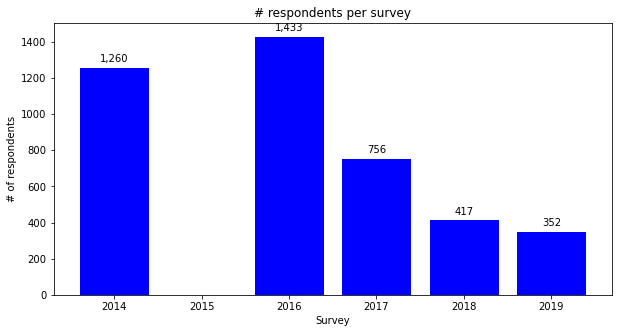

In [11]:
fig, ax = plt.subplots(figsize = (10,5))

respondents = plt.bar(responses.SurveyID, responses.NumOfRespondents, 
                       color = 'blue', edgecolor = 'white')

plt.xlabel('Survey')
plt.ylabel('# of respondents')
plt.title('# respondents per survey')

def autolabel(graph):
    for i in graph:
        height = i.get_height()
        ax.annotate('{:0,.0f}'.format(height),
            xy = (i.get_x() + i.get_width() / 2, height),
            xytext = (0, 3),
            textcoords = "offset points",
            ha = 'center', va = 'bottom')

autolabel(respondents)

plt.show()

Number of respondents varies per surveys:
- On 2014 there was collected 1260 participants responses. 
- Survey was skipped on 2015. 
- Then, on 2016 1433 participants were. 
- And since 2017 number of participants deacreased two times up to 352 on 2019 survey. 

### What are the surveys gender composition?

Gender answers were collected under this question in surveys:

`2 What is your gender?`

In [12]:
survey_df['Sex'] = survey_df.Sex.apply(lambda x: str(x.lower()))
survey_df.Sex.unique()

array(['female', 'male', 'male-ish', 'trans-female',
       'something kinda male?', 'queer/she/they', 'non-binary', 'nah',
       'all', 'enby', 'fluid', 'genderqueer', 'androgyne', 'agender',
       'guy (-ish) ^_^', 'male leaning androgynous', 'trans woman',
       'neuter', 'female (trans)', 'queer', 'a little about you', 'p',
       'ostensibly male, unsure what that really means', 'bigender',
       'female assigned at birth', 'fm', 'transitioned, m2f',
       'genderfluid (born female)', 'other/transfeminine',
       'female or multi-gender femme', 'androgynous',
       'male 9:1 female, roughly', '-1', 'other', 'nb masculine',
       'none of your business', 'human', 'genderfluid',
       'genderqueer woman', 'mtf', 'male/genderqueer', 'nonbinary',
       'unicorn', 'male (trans, ftm)', 'genderflux demi-girl',
       'female-bodied; no feelings about gender', 'afab',
       'transgender woman', 'male/androgynous',
       'uhhhhhhhhh fem genderqueer?', 'god king of the valajar',

There is a lot messy gender answers from surveys. We will standartize the answers to have comparable data.

In [13]:
gender = {"female": "female",
          "male": "male",
          "trans-female": "trans-woman",
          "non-binary": "non-binary",
          "fluid": "fluid",
          "androgyne": "androgyne",
          "queer": "queer",
          "bigender": "bi-gender",
          "other": "other",
          "male-ish": "male",
          "something kinda male?": "male",
          "queer/she/they": "queer",
          "nah": "other",
          "all": "other",
          "enby": "non-binary",
          "genderqueer": "queer",
          "agender": "other",
          "guy (-ish) ^_^": "male",
          "male leaning androgynous": "androgyne",
          "trans woman": "trans-woman",
          "neuter": "other",
          "female (trans)": "trans-woman",
          "a little about you": "other",
          "p": "other",
          "ostensibly male, unsure what that really means": "other",
          "female assigned at birth": "female", 
          "fm": "female",
          "transitioned, m2f": "trans-woman",
          "genderfluid (born female)": "fluid",
          "other/transfeminine": "trans-woman",
          "female or multi-gender femme": "female",
          "androgynous": "androgyne",
          "male 9:1 female, roughly": "male",
          "-1": "other",
          "nb masculine": "male",
          "none of your business": "other",
          "human": "other",
          "genderfluid": "fluid",
          "genderqueer woman": "queer",
          "mtf": "other",
          "male/genderqueer": "queer",
          "nonbinary": "non-binary",
          "unicorn": "other", 
          "male (trans, ftm)": "trans-gender",
          "genderflux demi-girl": "fluid",
          "female-bodied; no feelings about gender": "female",
          "afab": "other",
          "transgender woman": "trans-woman",
          "male/androgynous": "androgyne",
          "uhhhhhhhhh fem genderqueer?": "queer",
          "god king of the valajar": "other",
          "agender/genderfluid": "fluid",
          "sometimes": "other",
          "woman-identified": "female",
          "contextual": "other",
          "non binary": "non-binary",
          "genderqueer demigirl": "queer",
          "genderqueer/non-binary": "non-binary",
          "female-ish": "female",
          "\\-": "other",
          "transfeminine": "trans-woman",
          "none": "other",
          "ostensibly male": "male",
          "male (or female, or both)": "other",
          "trans man": "trans-male",
          "transgender": "trans-gender",
          "female/gender non-binary.": "non-binary",
          "demiguy": "other",
          "trans female": "trans-woman", 
          "she/her/they/them": "female",
          "swm": "other", 
          "nb": "other",
          "nonbinary/femme": "non-binary",
          "gender non-conforming woman": "female", 
          "masculine": "male",
          "cishet male": "male", 
          "female-identified": "female", 
          "questioning": "other",
          "i have a penis": "male", 
          "rr": "other", 
          "agender trans woman": "trans-woman", 
          "femmina": "female", 
          "43": "other",
          "masculino": "male", 
          "i am a wookie": "other", 
          "trans non-binary/genderfluid": "non-binary",
          "non-binary and gender fluid": "non-binary"
}

survey_df['Gender'] = survey_df.Sex.apply(lambda x: gender[x])
survey_df['GenderAgg'] = np.where(survey_df.Gender == 'female', 'female',
                              np.where(survey_df.Gender == 'male','male','other'))
survey_df.head(5)

,SurveyID,UserID,Age,Sex,CountryLiveIn,USStateLiveIn,SelfEmployed,FamilyHistoryMentalIllness,TreatmentForMentalHealthDisorder,EmployeesNumber,...,CountryWorkIn,USStateWorkIn,ConditionsDiagnosed,ProductivityEffect,WorkInterfenceEffect,DisccussMHDCoworkers,DisccussMHDSupervisor,Benefits,Gender,GenderAgg
0,2014,1,37,female,United States,Illinois,-1,No,1,6-25,...,None,None,None,None,Often,None,None,Yes,female,female
1,2014,2,44,male,United States,Indiana,-1,No,0,More than 1000,...,None,None,None,None,Rarely,None,None,Don't know,male,male
2,2014,3,32,male,Canada,-1,-1,No,0,6-25,...,None,None,None,None,Rarely,None,None,No,male,male
3,2014,4,31,male,United Kingdom,-1,-1,Yes,1,26-100,...,None,None,None,None,Often,None,None,No,male,male
4,2014,5,31,male,United States,Texas,-1,No,0,100-500,...,None,None,None,None,Never,None,None,Yes,male,male


After data standartization we can check the surveys gender composition:

In [14]:
responses_per_gender = (survey_df.groupby(['SurveyID','Gender'])
                             .agg(NumOfRespondents = ('UserID','count'))
                             .reset_index())
responses_per_gender_tot = (responses_per_gender.groupby('SurveyID')
                               .agg(Tot = ('NumOfRespondents','sum'))
                                .reset_index())
responses_per_gender = pd.merge(responses_per_gender, responses_per_gender_tot,
                                how = 'left',
                                on = 'SurveyID')
responses_per_gender['Share'] = round(responses_per_gender.NumOfRespondents /
                                        responses_per_gender.Tot*100,1)

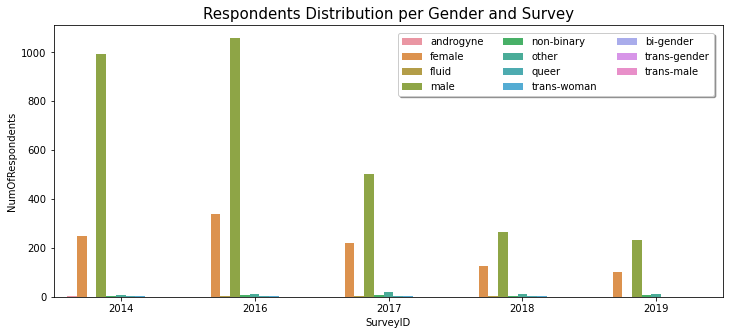

In [15]:
fig, ax = plt.subplots(figsize = (12,5))

sns.barplot(data = responses_per_gender, 
            x = "SurveyID",
            y = "NumOfRespondents", 
            hue = "Gender"
           )
plt.title("Respondents Distribution per Gender and Survey", fontsize = 15)
ax.legend(loc='upper center', bbox_to_anchor = (0.75, 0.99),
          ncol = 3, fancybox = True, shadow = True)

There are more males participating in the surveyes than females or other gender participants.

<Figure size 720x360 with 0 Axes>

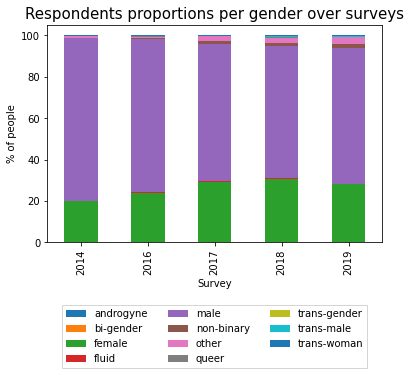

In [16]:
table = pd.pivot_table(responses_per_gender, 
                   values = 'Share', 
                   index = ['SurveyID'],
                   columns = ['Gender'], 
                   aggfunc = np.sum).fillna(0)

plt.figure(figsize = (10, 5)) 

table.plot(kind = 'bar', stacked=True)
plt.xlabel('Survey')
plt.ylabel('% of people')
 
# title of plot
plt.title('Respondents proportions per gender over surveys', fontsize = 15)
plt.legend(loc = 'lower center', bbox_to_anchor = (0.5, -0.6),
          ncol = 3, fancybox = False, shadow = False)

Over time surveys gender proportions changed: proportion of males slightly decreased and females increased. 

In last 3 years more people specified other genders than male and female.

In [17]:
survey_df.groupby('GenderAgg').UserID.count()

GenderAgg
female    1034
male      3054
other      130
Name: UserID, dtype: int64

### What are the surveys age composition?

Age information was under this question:

`1 What is your age?`

In [18]:
survey_df.Age.unique()

array(['37', '44', '32', '31', '33', '35', '39', '42', '23', '29', '36',
       '27', '46', '41', '34', '30', '40', '38', '50', '24', '18', '28',
       '26', '22', '19', '25', '45', '21', '-29', '43', '56', '60', '54',
       '329', '55', '-1', '48', '20', '57', '58', '47', '62', '51', '65',
       '49', '5', '53', '61', '8', '11', '72', '52', '17', '63', '99',
       '323', '3', '66', '59', '15', '74', '70', '64', '67', '0'],
      dtype=object)

In [19]:
survey_df['Age'] = survey_df.Age.apply(lambda x: int(x))

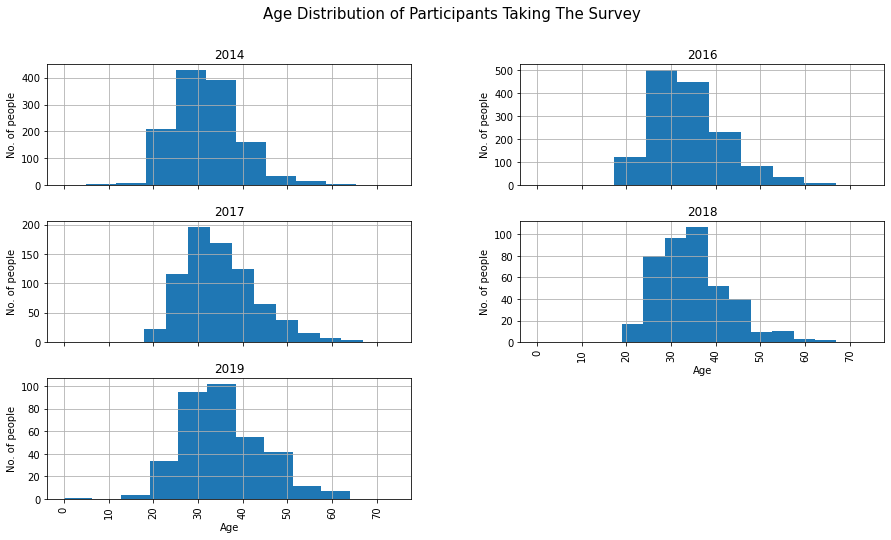

In [20]:
age_group = survey_df[['SurveyID', 'Age']]
age_dict = {}

survey_years = list(survey_df.SurveyID.unique())

for year in survey_years:
    age_dict[year] = (age_group[(age_group.SurveyID == year) & 
                                (age_group.Age.astype('int') >= 0) & 
                                (age_group.Age.astype('int') <= 90)] 
                        .Age  
                        .sort_values() 
                        .tolist())
    
axarr = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in age_dict.items() ])) \
        .hist(
            figsize = (15,8), 
            xrot = 90,sharex = True
        )
for ax in axarr.flatten():
    ax.set_xlabel("Age")
    ax.set_ylabel("No. of people")
    
plt.suptitle("Age Distribution of Participants Taking The Survey", fontsize = 15)
plt.savefig("./Age Distribution.png", dpi = 600, transparent = True)

All years taken survey age distributions are a bit right-skewed, almost bell shape, unimodal distributions (having one peak), centered at about 35 age. 

They are spread from 20-65 and have few outliers below 20 and more than 65. 

As age distributions are right-skewed, we would expect to see  that the mean will be higher than the median.


Text(0.5, 0.98, 'Age Distribution of Participants Taking The Survey')

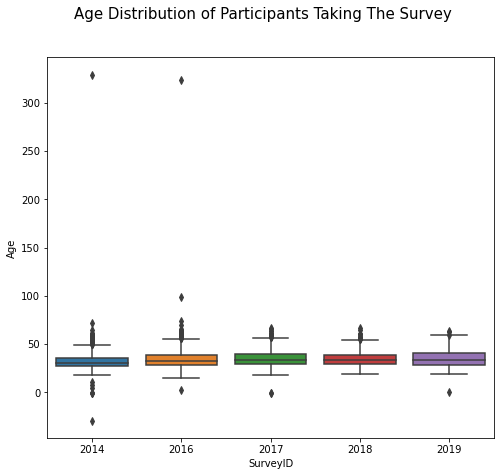

In [21]:
fig, ax = plt.subplots(figsize = (8,7))

sns.boxplot(data = survey_df, x = 'SurveyID', y = 'Age')
plt.suptitle('Age Distribution of Participants Taking The Survey', fontsize = 15)

Boxplots graphs shows that there are few outliers on each year surveys. We can see age below 0 or more than 100 years all. Such age is impossible and not logical. Thus such data could be exluded later in the analysis.

Age variability ranges are very similar per each survey.

In [22]:
# 25th Percentile
def q25(x):
    return x.quantile(0.25)
# 50th Percentile
def q50(x):
    return x.quantile(0.5)
# 75th Percentile
def q75(x):
    return x.quantile(0.75)
def IQR(x):
    return x.quantile(0.75) - x.quantile(0.25)

In [23]:
Age_Stats = (survey_df.groupby(['SurveyID'])
                      .agg({'Age': ['min',q25,'mean',q50,q75,'max',IQR]}))
Age_Stats

Age                                          
         min    q25       mean   q50   q75  max    IQR
SurveyID                                              
2014     -29  27.00  32.134921  31.0  36.0  329   9.00
2016       3  28.00  34.286113  33.0  39.0  323  11.00
2017      -1  29.00  34.892857  34.0  40.0   67  11.00
2018      19  29.00  34.916067  34.0  39.0   67  10.00
2019       0  28.75  35.494318  34.0  41.0   64  12.25

IQR (interquartile range, Q3-Q1) - is increasing years by years per surveys. Which says that variability of participants age was slighly increasing. 

The median and mean increased, too. Which says that slighly older people was involved in these surveys.

The average age of the participant in the survey was between 32-35 years.
Median was 31-34.

The one of the youngest participants were around 27-29 yearsold (25th percentile) and oldest were around 36-41 years old (75th percentile)

### What is the geographical respondents distribution?

Geographical answers was under question:

`3 What country do you live in?`

In [24]:
print('Raw values: \n', survey_df.CountryLiveIn.unique())

survey_df['CountryLiveIn'] = np.where(
            survey_df.CountryLiveIn == 'United States of America', 'United States',
              np.where(survey_df.CountryLiveIn == '-1', 'Other', 
               survey_df.CountryLiveIn)
            )

Raw values: 
 ['United States' 'Canada' 'United Kingdom' 'Bulgaria' 'France' 'Portugal'
 'Netherlands' 'Switzerland' 'Poland' 'Australia' 'Germany' 'Russia'
 'Mexico' 'Brazil' 'Slovenia' 'Costa Rica' 'Austria' 'Ireland' 'India'
 'South Africa' 'Italy' 'Sweden' 'Colombia' 'Latvia' 'Romania' 'Belgium'
 'New Zealand' 'Zimbabwe' 'Spain' 'Finland' 'Uruguay' 'Israel'
 'Bosnia and Herzegovina' 'Hungary' 'Singapore' 'Japan' 'Nigeria'
 'Croatia' 'Norway' 'Thailand' 'Denmark' 'Bahamas, The' 'Greece' 'Moldova'
 'Georgia' 'China' 'Czech Republic' 'Philippines'
 'United States of America' 'Lithuania' 'Venezuela' 'Argentina' 'Vietnam'
 'Slovakia' 'Bangladesh' 'Algeria' 'Pakistan' 'Afghanistan' 'Other'
 'Brunei' 'Iran' 'Ecuador' 'Chile' 'Guatemala' 'Taiwan' 'Serbia' 'Estonia'
 'Iceland' 'Indonesia' 'Jordan' 'Ukraine' 'Belarus' 'Turkey' '-1'
 'Mauritius' 'Saudi Arabia' 'Kenya' 'Ethiopia' 'Macedonia' 'Hong Kong'
 'Ghana']


In [25]:
country = (survey_df.groupby(['SurveyID','CountryLiveIn'])
                     .agg(NumPeople = ('UserID','nunique'))
                     .reset_index())
country_pt = pd.pivot_table(country, 
                    values = 'NumPeople', 
                    index = ['CountryLiveIn'],
                    columns = ['SurveyID'], 
                    aggfunc = np.sum, 
                    fill_value = 0 )

print('Top 15 countries respondents lives in:')
(country_pt.sort_values(by = 2014, ascending = False)
     .head(15).style.background_gradient(cmap = 'PuBu'))

Top 15 countries respondents lives in:


SurveyID,2014,2016,2017,2018,2019
CountryLiveIn,,,,,
United States,751,840,497,312,204
United Kingdom,185,180,66,19,32
Canada,72,78,26,8,15
Germany,45,58,22,7,4
Netherlands,27,48,14,5,4
Ireland,27,15,4,3,2
Australia,22,35,12,4,0
France,13,16,17,4,1
India,10,9,13,5,13


The most participants were from United States and Unted Kingdom

### Other survey values checks, preparation

In [26]:
survey_df.groupby('IsTechCompany').UserID.count()
survey_df['IsTechCompany'] = np.where(survey_df.IsTechCompany == 1, True, False)

In [27]:
survey_df.groupby('SelfEmployed').UserID.count() 
survey_df.groupby('FamilyHistoryMentalIllness').UserID.count() 
survey_df.groupby('TreatmentForMentalHealthDisorder').UserID.count() 
survey_df.groupby('HadMentalHealthDisorder').UserID.count() 
survey_df.groupby('HasMentalHealthDisorder').UserID.count() 
survey_df.groupby('HaveDiagnosedMHD').UserID.count() 

survey_df['HaveDiagnosedMHD'] = np.where(survey_df.HaveDiagnosedMHD == '-1', 
                                         'No', 
                                         survey_df.HaveDiagnosedMHD)

survey_df.groupby('HaveDiagnosedMHD').UserID.count() 
survey_df.groupby('HadMentalHealthDisorder').UserID.count() 

HadMentalHealthDisorder
-1              15
Don't Know     109
Maybe          246
No             896
Possibly       275
Yes           1417
Name: UserID, dtype: int64

In [28]:
print(survey_df.ConditionsDiagnosed.unique())
survey_df['ConditionsMHD'] = np.where(survey_df.ConditionsDiagnosed == '-1', 
                                      None, 
                                      survey_df.ConditionsDiagnosed)

[None '-1' 'Mood Disorder (Depression, Bipolar Disorder, etc)'
 'Stress Response Syndromes' 'Substance Use Disorder'
 'Anxiety Disorder (Generalized, Social, Phobia, etc)'
 'Obsessive-Compulsive Disorder'
 'Personality Disorder (Borderline, Antisocial, Paranoid, etc)'
 'Attention Deficit Hyperactivity Disorder'
 'Post-traumatic Stress Disorder'
 'Pervasive Developmental Disorder (Not Otherwise Specified)'
 'Seasonal Affective Disorder' 'Burn out' 'PDD-NOS' 'Depression'
 "Autism (Asperger's)" 'Traumatic Brain Injury' 'Addictive Disorder'
 'Asperges' 'PTSD (undiagnosed)'
 'Psychotic Disorder (Schizophrenia, Schizoaffective, etc)'
 'Sexual addiction'
 'Combination of physical impairment (strongly near-sighted) with a possibly mental one (MCD / "ADHD", though its actually a stimulus filtering impairment)'
 "I haven't been formally diagnosed, so I felt uncomfortable answering, but Social Anxiety and Depression."
 'Autism Spectrum Disorder' 'Transgender' 'Dissociative Disorder'
 'Eating Diso

## Analysis

### How often mental heath disorder (MHD) is met among the tech workplace?

We want to check how often MHD is met among tech workplace. Based on these questions below we will calcualte the ratio of people facing MHD.

Questions:
- (32) Have you had a mental health disorder in the past?
- (33) Do you currently have a mental health disorder?
- (34) Have you ever been diagnosed with a mental health disorder?

In [29]:
mappings = {'Don\'t Know': 'No',
            'Maybe': 'Yes',
            'No': 'No',
            'Possibly': 'Yes',
            'Yes': 'Yes',
            '-1': 'No'
           }
survey_df['HasMHD'] = survey_df['HasMentalHealthDisorder'].replace(mappings)
survey_df['HasMHD'].value_counts()

survey_df['HadMHD'] = survey_df['HadMentalHealthDisorder'].replace(mappings)
survey_df['HadMHD'].value_counts()

Yes    1938
No     1020
Name: HadMHD, dtype: int64

In [30]:
(survey_df.groupby(['HasMHD',
                'HadMHD',
                'HaveDiagnosedMHD'])
           .agg(NumPeople = ('UserID','count'))
           .reset_index()
            )

,HasMHD,HadMHD,HaveDiagnosedMHD,NumPeople
0,No,No,No,787
1,No,No,Yes,2
2,No,Yes,No,225
3,No,Yes,Yes,79
4,Yes,No,No,163
5,Yes,No,Yes,68
6,Yes,Yes,No,420
7,Yes,Yes,Yes,1214


In [31]:
mhd_ = (survey_df.groupby(['SurveyID','HaveDiagnosedMHD'])
           .agg(NumPeople = ('UserID','count'))
           .reset_index()
            )
mhd_tot = mhd_.groupby('SurveyID').agg(Tot = ('NumPeople','sum')).reset_index()
mhd_ = pd.merge(mhd_, mhd_tot, how = 'left',on = 'SurveyID')
mhd_['Share'] = round(mhd_.NumPeople/mhd_.Tot*100,1)
mhd_

,SurveyID,HaveDiagnosedMHD,NumPeople,Tot,Share
0,2016,No,717,1433,50.0
1,2016,Yes,716,1433,50.0
2,2017,No,442,756,58.5
3,2017,Yes,314,756,41.5
4,2018,No,228,417,54.7
5,2018,Yes,189,417,45.3
6,2019,No,208,352,59.1
7,2019,Yes,144,352,40.9


In [32]:
# Had MHD
mhd_had = (survey_df.groupby(['SurveyID','HadMHD'])
           .agg(NumPeople = ('UserID','count'))
           .reset_index()
            )
mhd_had_tot = mhd_had.groupby('SurveyID').agg(Tot = ('NumPeople','sum')).reset_index()
mhd_had = pd.merge(mhd_had, mhd_had_tot, how = 'left',on = 'SurveyID')
mhd_had['Share'] = round(mhd_had.NumPeople/mhd_had.Tot*100,1)

# Has MHD
mhd_has = (survey_df.groupby(['SurveyID','HasMHD'])
           .agg(NumPeople = ('UserID','count'))
           .reset_index()
            )
mhd_has_tot = mhd_has.groupby('SurveyID').agg(Tot = ('NumPeople','sum')).reset_index()
mhd_has = pd.merge(mhd_has, mhd_has_tot, how = 'left',on = 'SurveyID')
mhd_has['Share'] = round(mhd_has.NumPeople/mhd_has.Tot*100,1)

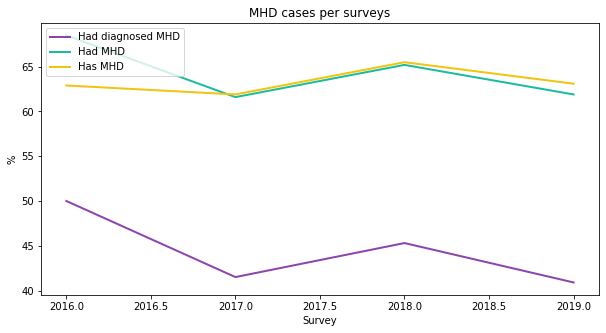

In [33]:
fig, ax = plt.subplots(figsize = (10,5))

surv = mhd_.SurveyID.unique().tolist()
mhd_no = mhd_[mhd_.HaveDiagnosedMHD == 'No'].reset_index()
mhd_yes = mhd_[mhd_.HaveDiagnosedMHD == 'Yes'].reset_index()
mhd_yes_had = mhd_had[mhd_had.HadMHD == 'Yes'].reset_index()
mhd_yes_has = mhd_has[mhd_has.HasMHD == 'Yes'].reset_index()

line1 = plt.plot(surv, mhd_yes.Share, 
                 linewidth = 2.0, 
                 color = '#8E44AD', 
                 label = 'Had diagnosed MHD')
line2 = plt.plot(surv, mhd_yes_had.Share, 
                 linewidth = 2.0, 
                 color = '#1ABC9C', 
                 label = 'Had MHD')
line3 = plt.plot(surv, mhd_yes_has.Share, 
                 linewidth = 2.0, 
                 color = '#F1C40F', 
                 label = 'Has MHD')

plt.legend(loc = 'upper left')

plt.xlabel('Survey')
plt.ylabel('%')
plt.title('MHD cases per surveys')
plt.show()

- There is quite many respondents who have or had MHD (more than 60%). The percentage remains high over all surveys taken per years.
- % of respondents saying that they have diagnozed MHD varies per survey. However it is quite high percentage rate of people having diagnozed MHD (40-45% from total respondents per survey)

### What conditions of MHD is most often met?

*MHD conditions question was provided and collected the answers only on 2016 yers survey.

In [34]:
mhd_type = (survey_df[survey_df.SurveyID == 2016].groupby(['ConditionsMHD'])
           .agg(NumPeople = ('UserID','count'))
           .reset_index()
            )
mhd_type['Share'] = round(mhd_type.NumPeople/mhd_type.NumPeople.sum()*100,1)
mhd_type

mhd_type['ConditionsMHD_percent'] = mhd_type.apply(lambda x:
                                        x.ConditionsMHD + ': ' + str(x.Share) + '%', axis = 1)

mhd_type.head(3)

,ConditionsMHD,NumPeople,Share,ConditionsMHD_percent
0,Addictive Disorder,1,0.2,Addictive Disorder: 0.2%
1,"Anxiety Disorder (Generalized, Social, Phobia,...",47,8.3,"Anxiety Disorder (Generalized, Social, Phobia,..."
2,Asperges,1,0.2,Asperges: 0.2%


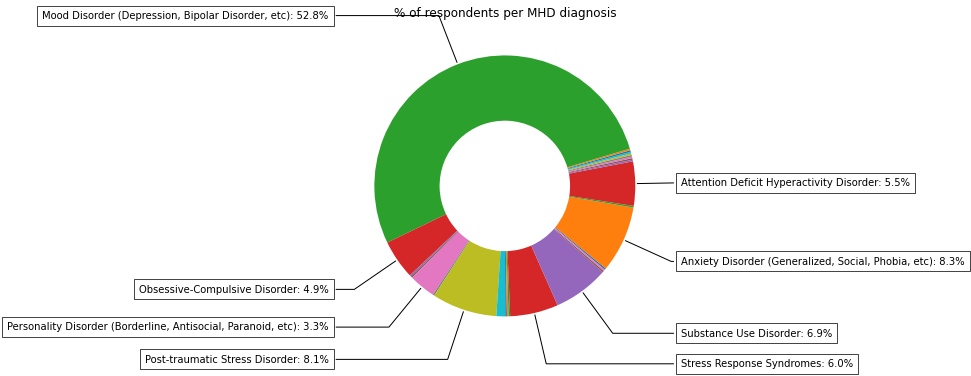

In [35]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw = dict(aspect = 'equal'))

diagnosis = mhd_type.ConditionsMHD_percent.to_list()

percent_diagnosis = mhd_type.Share.to_list()

wedges, texts = ax.pie(percent_diagnosis, wedgeprops = dict(width = 0.5), startangle = -40)

bbox_props = dict(boxstyle = 'square,pad=0.5', fc = 'w', ec = 'k', lw = 0.72)
kw = dict(arrowprops = dict(arrowstyle='-'),
          bbox = bbox_props, zorder = 0, va = 'center')

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: 'right', 1: 'left'}[int(np.sign(x))]
    connectionstyle = 'angle,angleA=0,angleB={}'.format(ang)
    kw['arrowprops'].update({'connectionstyle': connectionstyle})
    
    if float(diagnosis[i].split(': ')[1][:-1]) >= 2:
        ax.annotate(diagnosis[i], xy  =(x, y), xytext = (1.35*np.sign(x), 1.4*y),
                horizontalalignment = horizontalalignment, **kw)

ax.set_title('% of respondents per MHD diagnosis')

plt.show()

- A bit more than half respondents mentioned that they have MHD diagnozis of Mood disorders (Depresion, Bipolar disorder, etc) 52.8%.
- 8.3% said they have Anxiet Disorder (Generalized, Social, Phobia).
- In third place most often mentioned MHD was Post-traymatic Stress Discorder (8.1%)
- As well respondents say they struggle from Substance use, stress response syndrome, attention deficit, hyperactivity, obsessive-compulsives disorders.

### Is there any differences per gender of having MHD?

In [40]:
mhd_gender_has = (survey_df.groupby(['SurveyID','GenderAgg','HasMHD'])
           .agg(NumPeople = ('UserID','count'))
           .reset_index()
            )

mhd_gender_has_tot = (mhd_gender_has.groupby(['SurveyID','GenderAgg'])
                              .agg(Tot = ('NumPeople','sum'))
                              .reset_index()
                     )
mhd_gender_has = pd.merge(mhd_gender_has, mhd_gender_has_tot, 
                          how = 'left', 
                          on = ['SurveyID','GenderAgg'])
mhd_gender_has['Share'] = round(mhd_gender_has.NumPeople/mhd_gender_has.Tot*100,1)
mhd_gender_has

mhd_gender_has_pt = pd.pivot_table(mhd_gender_has, 
                       values='Share', 
                       index = ['SurveyID'],
                       columns = ['GenderAgg', 'HasMHD'],
                       aggfunc = np.sum)
mhd_gender_has_pt

GenderAgg female        male       other      
HasMHD        No   Yes    No   Yes    No   Yes
SurveyID                                      
2016        29.4  70.6  40.6  59.4   2.9  97.1
2017        29.1  70.9  43.5  56.5  15.2  84.8
2018        23.6  76.4  40.1  59.9  30.4  69.6
2019        27.0  73.0  42.0  58.0  28.6  71.4

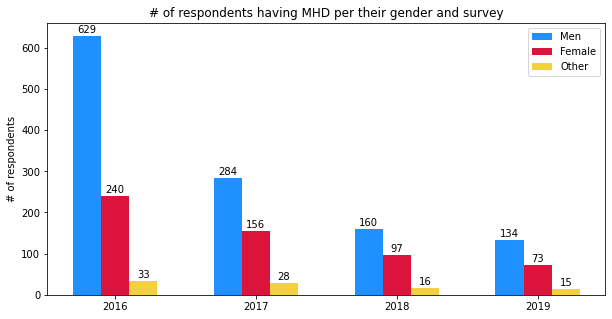

In [37]:
fig, ax = plt.subplots(figsize = (10,5))

mhd_gender_has_ = mhd_gender_has[mhd_gender_has.HasMHD == 'Yes'].reset_index()

labels = list(mhd_gender_has_.SurveyID.unique())

men_ = list(mhd_gender_has_[mhd_gender_has_.GenderAgg == 'male'].NumPeople)
female_ = list(mhd_gender_has_[mhd_gender_has_.GenderAgg == 'female'].NumPeople)
other_ = list(mhd_gender_has_[mhd_gender_has_.GenderAgg == 'other'].NumPeople)


x = np.arange(len(labels))
width = 0.2

men_plt = ax.bar(x - 0.2, men_, width, label = 'Men', color = '#1E90FF')
female_plt = ax.bar(x, female_, width, label = 'Female', color = '#DC143C')
other_plt = ax.bar(x + 0.2, other_, width, label = 'Other', color = '#F4D03F')

ax.set_ylabel('# of respondents')
ax.set_title('# of respondents having MHD per their gender and survey')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(men_plt, padding = 1)
ax.bar_label(female_plt, padding = 1)
ax.bar_label(other_plt, padding = 1)

plt.show()

There are significantly more males who said they have MHD. The nominal number of males having MHD decreases over surveys, but remains highest compared to other genders: e.g. twice more than females and up to 10 times more than other genders.

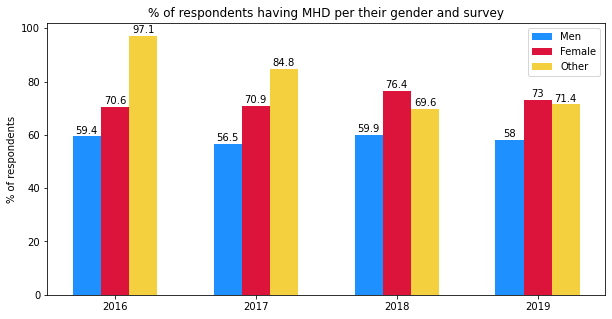

In [38]:
fig, ax = plt.subplots(figsize = (10,5))

mhd_gender_has_ = mhd_gender_has[mhd_gender_has.HasMHD == 'Yes'].reset_index()

labels = list(mhd_gender_has_.SurveyID.unique())

men_ = list(mhd_gender_has_[mhd_gender_has_.GenderAgg == 'male'].Share)
female_ = list(mhd_gender_has_[mhd_gender_has_.GenderAgg == 'female'].Share)
other_ = list(mhd_gender_has_[mhd_gender_has_.GenderAgg == 'other'].Share)


x = np.arange(len(labels))
width = 0.2

men_plt = ax.bar(x - 0.2, men_, width, label = 'Men', color = '#1E90FF')
female_plt = ax.bar(x, female_, width, label = 'Female', color = '#DC143C')
other_plt = ax.bar(x + 0.2, other_, width, label = 'Other', color = '#F4D03F')

ax.set_ylabel('% of respondents')
ax.set_title('% of respondents having MHD per their gender and survey')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(men_plt, padding = 1)
ax.bar_label(female_plt, padding = 1)
ax.bar_label(other_plt, padding = 1)

plt.show()

However, the proportions having MHD differs significantly from nominal numbers:
- In latest surveys more women and other gender people say they have MHD (more than 70%)
- Then males proportion is up to 60% say they have MHD.
- It looks like that more often MHD has womens and other gender people.

### Are there certain age groups where MHD are met more often?

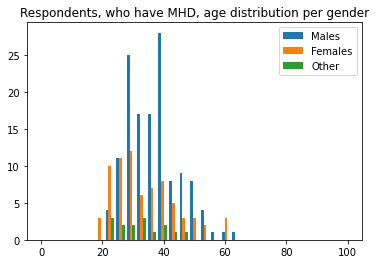

In [41]:
age_group = survey_df[(survey_df.SurveyID == 2019) &
                     (survey_df.HasMHD == 'Yes')][['SurveyID', 'GenderAgg','Age']].reset_index()

# fig, ax = plt.subplots(2)
fig.suptitle('Vertically stacked subplots')
bins = np.linspace(0, 100, 30)

males_ = age_group[age_group.GenderAgg == 'male'].Age
females_ = age_group[age_group.GenderAgg == 'female'].Age
other_ = age_group[age_group.GenderAgg == 'other'].Age

plt.title('Respondents, who have MHD, age distribution per gender')
plt.hist([males_, females_, other_], bins, label = ['Males', 'Females', 'Other'])
plt.legend(loc='upper right')
plt.show()

- Other gender age distribution is more flatten and within range of 20-50 years all.
- While females and males age distributions are binomial distributions with 2 peaks on 30s and 40s years, skewed to the right.

In [42]:
age_bins = [0,10,20,30,40,50,60,70,80,90,100]
survey_df['AgeBins'] = pd.cut(survey_df['Age'], age_bins).astype(str)

age_group = (survey_df[(survey_df.SurveyID == 2019) &
                     (survey_df.HasMHD == 'Yes')]
                     .groupby(['GenderAgg','AgeBins'])
                     .agg(NumPeople=('UserID','count'))
                     .reset_index()
            )
age_group_tot = (age_group.groupby('GenderAgg')
                     .agg(Tot = ('NumPeople','sum'))
                     .reset_index()
                )
age_group = pd.merge(age_group,age_group_tot, how = 'left', on = 'GenderAgg')
age_group['Share'] = round(age_group.NumPeople/age_group.Tot*100,1)
age_group =pd.pivot_table(age_group, 
                          values = ['NumPeople','Share'], 
                          index = 'AgeBins',
                          columns = ['GenderAgg'], 
                          aggfunc = np.sum, 
                          fill_value = 0)
age_group = age_group.reset_index()
age_group.columns = [['AgeBins', 'female_num', 'male_num', 'other_num', 'female_p', 'male_p', 'other_p']] 
age_group

,AgeBins,female_num,male_num,other_num,female_p,male_p,other_p
0,"(10, 20]",3,0,0,4.1,0.0,0
1,"(20, 30]",32,34,6,43.8,25.4,40
2,"(30, 40]",22,61,6,30.1,45.5,40
3,"(40, 50]",10,29,3,13.7,21.6,20
4,"(50, 60]",6,9,0,8.2,6.7,0
5,"(60, 70]",0,1,0,0.0,0.7,0


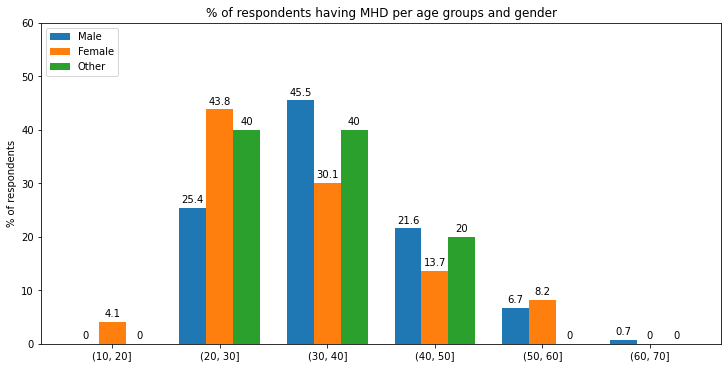

In [43]:
age_bins = list(itertools.chain(*age_group.AgeBins.values.tolist()))
gender_p = {
    'Male': list(itertools.chain(*age_group.male_p.values.tolist())),
    'Female': list(itertools.chain(*age_group.female_p.values.tolist())),
    'Other': list(itertools.chain(*age_group.other_p.values.tolist())),
}

x = np.arange(len(age_bins))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout = 'constrained',figsize = (10,5))

for attribute, measurement in gender_p.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label = attribute)
    ax.bar_label(rects, padding = 3)
    multiplier += 1
    
ax.set_ylabel('% of respondents')
ax.set_title('% of respondents having MHD per age groups and gender')
ax.set_xticks(x + width, age_bins)
ax.legend(loc = 'upper left')
ax.set_ylim(0, 60)

plt.show()

- There are more mid age males (30-40 years old) and more younger womens (between 20-30 years old) having MHD.  45.5% males and 43.8% females.
- There was a lot other gender people having MHD between 20-40 years old.
- Hovewer, in all age groups there is certain percentage of people having MHD.

In [44]:
age_group = (survey_df[(survey_df.SurveyID == 2019)]
                     .groupby(['HasMHD','GenderAgg','AgeBins'])
                     .agg(NumPeople = ('UserID','count'))
                     .reset_index()
            )
age_group_tot = (age_group.groupby(['GenderAgg','AgeBins'])
                     .agg(Tot = ('NumPeople','sum'))
                     .reset_index()
                )
age_group = pd.merge(age_group,age_group_tot, how = 'left', on = ['GenderAgg','AgeBins'])
age_group['Share'] = round(age_group.NumPeople/age_group.Tot*100,1)


age_group_pt = pd.pivot_table(age_group[age_group.HasMHD == 'Yes'], 
                              values = 'Share', 
                              index = ['AgeBins'],
                              columns = ['GenderAgg'], 
                              aggfunc = np.sum, 
                              fill_value = 0 )

(age_group_pt.style.background_gradient(cmap = 'PuBu'))

GenderAgg,female,male,other
AgeBins,,,
"(10, 20]",100.000000,0.000000,0.000000
"(20, 30]",72.700000,52.300000,85.700000
"(30, 40]",68.800000,62.200000,75.000000
"(40, 50]",83.300000,56.900000,50.000000
"(50, 60]",66.700000,75.000000,0.000000
"(60, 70]",0.000000,50.000000,0.000000


- Between 20-40 years all more other gender people has MHD.
- The highest proportion of females between 40-50 years have MHD, while males betwen 50-60 years.

### H0: The more employees organization has the more MHD cases could be meet

We want to test assumption wheter bigger organizations have the higher change to have more people suffering from MHD: due to higher stress, competition among the employees.

In [538]:
mappings = {'-1': 0,
            '1-5': 1,
            '6-25': 2,
            '26-100': 3,
            '100-500': 4,
            '500-1000': 5,
            'More than 1000': 6
           }

HasMHD_mapping = {'Yes': 1,
                  'No': 0
        }
survey_df['EmployeesNum'] = survey_df['EmployeesNumber'].replace(mappings)
survey_df['HasMHD_'] = survey_df['HasMHD'].replace(HasMHD_mapping)

In [539]:
np.corrcoef(survey_df[survey_df.SurveyID == 2019].HasMHD_, survey_df[survey_df.SurveyID == 2019].EmployeesNum)

array([[1.        , 0.01604365],
       [0.01604365, 1.        ]])

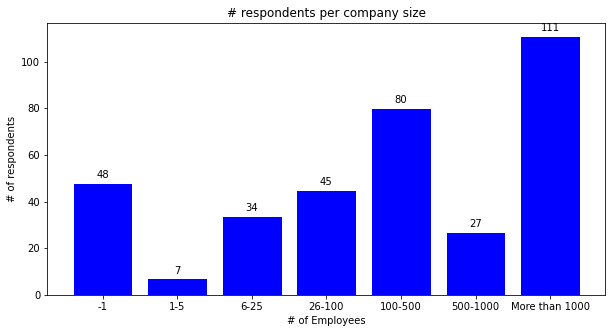

In [540]:
org_size = (survey_df[(survey_df.SurveyID == 2019)]
                .groupby(['EmployeesNumber','EmployeesNum'])
                .agg(NumPoeple = ('UserID', 'count'))
                .reset_index()
           ).sort_values(by = 'EmployeesNum')

fig, ax = plt.subplots(figsize = (10,5))

respondents = plt.bar(org_size.EmployeesNumber, org_size.NumPoeple, 
                       color = 'blue', edgecolor = 'white')

plt.xlabel('# of Employees')
plt.ylabel('# of respondents')
plt.title('# respondents per company size')

def autolabel(graph):
    for i in graph:
        height = i.get_height()
        ax.annotate('{:0,.0f}'.format(height),
                    xy = (i.get_x() + i.get_width() / 2, height),
                    xytext = (0, 3),
                    textcoords = 'offset points',
                    ha = 'center', va = 'bottom')

autolabel(respondents)

plt.show()

The bigger company is, the more respondents participated in the survey. But 500-1000 employees size company respondents were one of the smallest numbers among the survey.

In [541]:
company_size = (survey_df.groupby(['SurveyID','HasMHD','EmployeesNum','EmployeesNumber'])
                     .agg(NumPeople = ('UserID','nunique'))
                     .reset_index())

company_size_tot = (company_size.groupby('SurveyID')
                        .agg(Tot = ('NumPeople','sum'))
                        .reset_index()
                    )

company_size = pd.merge(company_size,company_size_tot,how = 'left',on = 'SurveyID')
company_size['Share'] = round(company_size.NumPeople/company_size.Tot*100,1)
company_size_pt = pd.pivot_table(company_size[company_size.HasMHD == 'Yes'], 
                     values = 'Share', 
                     index = ['EmployeesNum','EmployeesNumber'],
                     columns = ['HasMHD','SurveyID'], 
                     aggfunc = np.sum, fill_value = 0 )
(company_size_pt.style.background_gradient(cmap = 'PuBu'))

It is hard to find pattern that the bigger organization is, the more MHD people are there.
The percentage of MHD having people from total survey participants looks like increasing by the increasing number of employees per organization on all taken surveys. 

However, organizations having 500-1000 employees has realy low proportion of people having MHD.
But based on the survey respondents distribution per company size, we can see that there was small share of people from 500-1000 employees having companies. Thus, this could effect results and their interpretation, due to lacking representatives in this group.

### H0: People with MHD working at companies, which have benefits for mental health support, experience less work interfence and are more productive

If companie providers any benefits for the mental health was under this questions:

`10 Does your employer provide mental health benefits as part of healthcare coverage?`

Productivity answers:

`54 Do you believe your productivity is ever affected by a mental health issue?`

In [46]:
mappings = {"Yes": "Yes",
            "Don't know": "No",
            "No": "No",
            "Not eligible for coverage / NA": "No",
            "-1": "No",
            "I don't know": "No"
    }
survey_df['HasBenefit'] = survey_df['Benefits'].replace(mappings)

mappings_productivity = {"Yes": "Yes",
            "Not applicable to me": "No",
            "No": "No",
            "Unsure": "Unsure",
            "-1": "No",
            None: "No"
    }
survey_df['HasProductivityEffect'] = survey_df['ProductivityEffect'].replace(mappings_productivity)

mappings_WorkInterfenceEffect = {
    'Often': 'Often',
    'Rarely': 'Rarely',
    'Never': 'Never',
    'Sometimes': 'Sometimes',
    '-1': 'Never', 
    None: 'Never'}

survey_df['HasWorkInterfenceEffect'] = survey_df['WorkInterfenceEffect'].replace(mappings_WorkInterfenceEffect)

Let's take latest survey results and compare how many percentage of people who get and do not get mental health benefits experience productivity effects.

% of respondents from total:


<AxesSubplot:xlabel='HasMHD-HasProductivityEffect', ylabel='HasBenefit'>

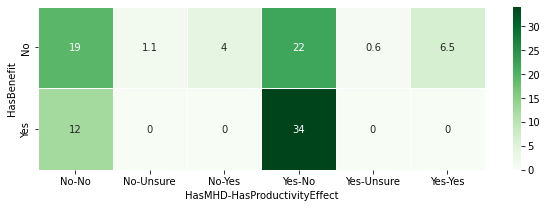

In [47]:
mhd_benefits = (survey_df[survey_df.SurveyID == 2019].groupby(['HasBenefit','HasMHD','HasProductivityEffect'])
           .agg(NumPeople=('UserID','count'))
           .reset_index()
            )

mhd_benefits['Share'] = round(mhd_benefits.NumPeople/mhd_benefits.NumPeople.sum()*100,1)

mhd_benefits_pt = pd.pivot_table(mhd_benefits, 
                     values = 'Share', 
                     index = ['HasBenefit'],
                     columns = ['HasMHD', 'HasProductivityEffect'], 
                     aggfunc = np.sum).fillna(0)

print("% of respondents from total:")
plt.figure(figsize = (10,3))
sns.heatmap(mhd_benefits_pt, cmap = 'Greens', linewidths = 0.5, annot = True)

34% from total respondents has MHD, works in companies having benefits for mental health and say they work productivity is not effected due to their condition. And 6.5% of respondents having MHD said they productivity is effected and do not get any mental heath benefit from company.

% of respondents from total:


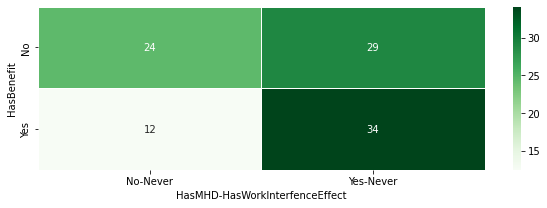

In [48]:
mhd_benefits = (survey_df[survey_df.SurveyID == 2019].groupby(['HasBenefit','HasMHD','HasWorkInterfenceEffect'])
           .agg(NumPeople = ('UserID','count'))
           .reset_index()
            )

mhd_benefits['Share'] = round(mhd_benefits.NumPeople/mhd_benefits.NumPeople.sum()*100,1)

mhd_benefits_pt = pd.pivot_table(mhd_benefits, 
                         values = 'Share', 
                         index = ['HasBenefit'],
                         columns = ['HasMHD', 'HasWorkInterfenceEffect'],
                         aggfunc = np.sum).fillna(0)

print("% of respondents from total:")
plt.figure(figsize = (10,3))
sns.heatmap(mhd_benefits_pt, cmap = 'Greens', linewidths = 0.5, annot = True)
plt.show()

In [484]:
survey_df.groupby(['HasWorkInterfenceEffect','SurveyID']).UserID.count()

HasWorkInterfenceEffect  SurveyID
Never                    2014         477
                         2016        1433
                         2017         756
                         2018         417
                         2019         352
Often                    2014         144
Rarely                   2014         173
Sometimes                2014         466
Name: UserID, dtype: int64

The newest information about work interfence is missing, there was no questions-answers to this questions on later years surveys

### H0: Over time confidence to share about MHD is changing, people became more open

To evaluate confidence, openes and willingness to talk and share about mental health we used these questions answers:

`18 Would you feel comfortable discussing a mental health issue with your coworkers?`

`19 Would you feel comfortable discussing a mental health issue with your direct supervisor(s)?`

In [545]:
mappings_disccuss = {
    'Yes': 'Yes',
    'No': 'No',
    'Maybe': 'Maybe',
    '-1': 'No', 
    None: 'No'}

survey_df['DoesDisccussMHDCoworkers'] = survey_df['DisccussMHDCoworkers'].replace(mappings_disccuss)
survey_df['DoesDisccussMHDSupervisor'] = survey_df['DisccussMHDSupervisor'].replace(mappings_disccuss)

<b>Sharing with cowokers: </b>

In [546]:
mhd_discuss_co = (survey_df.groupby(['SurveyID','DoesDisccussMHDCoworkers','HasMHD'])
           .agg(NumPeople = ('UserID','count'))
           .reset_index()
            )
mhd_discuss_co

mhd_discuss_co_tot = (mhd_discuss_co.groupby(['SurveyID','DoesDisccussMHDCoworkers'])
                              .agg(Tot = ('NumPeople','sum'))
                              .reset_index()
                     )
mhd_discuss_co = pd.merge(mhd_discuss_co, mhd_discuss_co_tot,
                          how = 'left',
                          on = ['SurveyID','DoesDisccussMHDCoworkers'])
mhd_discuss_co['Share'] = round(mhd_discuss_co.NumPeople/mhd_discuss_co.Tot*100,1)


mhd_discuss_co_pt = pd.pivot_table(mhd_discuss_co, 
                       values = 'Share', 
                       index = ['SurveyID'],
                       columns = ['DoesDisccussMHDCoworkers', 'HasMHD'], 
                       aggfunc = np.sum)

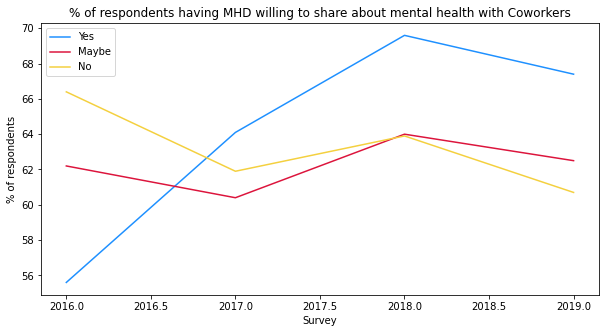

In [548]:
fig, ax = plt.subplots(figsize = (10,5))

mhd_has_ = mhd_discuss_co[mhd_discuss_co.HasMHD == 'Yes'].reset_index()

labels = list(mhd_has_.SurveyID.unique())

yes_ = list(mhd_has_[mhd_has_.DoesDisccussMHDCoworkers == 'Yes'].Share)
maybe_ = list(mhd_has_[mhd_has_.DoesDisccussMHDCoworkers == 'Maybe'].Share)
no_ = list(mhd_has_[mhd_has_.DoesDisccussMHDCoworkers == 'No'].Share)

yes_plt = plt.plot(labels, yes_, label = 'Yes', color = '#1E90FF')
maybe_plt = plt.plot(labels, maybe_, label = 'Maybe', color = '#DC143C')
no_plt = plt.plot(labels, no_, label = 'No', color = '#F4D03F')

plt.xlabel('Survey')
plt.ylabel('% of respondents')
plt.legend()
plt.title('% of respondents having MHD willing to share about mental health with Coworkers')
plt.show()

More percentage of people are willing to share about MHD with their colleagues over the time

<b>Sharing with superviser: </b>

In [45]:
mhd_discuss_sup = (survey_df.groupby(['SurveyID','DoesDisccussMHDSupervisor','HasMHD'])
           .agg(NumPeople = ('UserID','count'))
           .reset_index()
            )
mhd_discuss_sup

mhd_discuss_sup_tot = (mhd_discuss_sup.groupby(['SurveyID','DoesDisccussMHDSupervisor'])
                              .agg(Tot = ('NumPeople','sum'))
                              .reset_index()
                     )
mhd_discuss_sup = pd.merge(mhd_discuss_sup, mhd_discuss_sup_tot,
                           how = 'left',
                           on = ['SurveyID','DoesDisccussMHDSupervisor'])
mhd_discuss_sup['Share'] = round(mhd_discuss_sup.NumPeople/mhd_discuss_sup.Tot*100,1)


mhd_discuss_sup_pt = pd.pivot_table(mhd_discuss_sup, 
                        values = 'Share', 
                        index = ['SurveyID'],
                        columns = ['DoesDisccussMHDSupervisor', 'HasMHD'], 
                        aggfunc = np.sum)
mhd_discuss_sup_pt

KeyError: 'DoesDisccussMHDSupervisor'

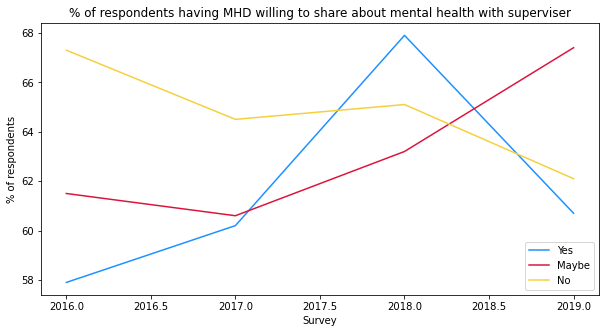

In [550]:
fig, ax = plt.subplots(figsize = (10,5))

mhd_has_ = mhd_discuss_sup[mhd_discuss_sup.HasMHD == 'Yes'].reset_index()

labels = list(mhd_has_.SurveyID.unique())

yes_ = list(mhd_has_[mhd_has_.DoesDisccussMHDSupervisor == 'Yes'].Share)
maybe_ = list(mhd_has_[mhd_has_.DoesDisccussMHDSupervisor == 'Maybe'].Share)
no_ = list(mhd_has_[mhd_has_.DoesDisccussMHDSupervisor == 'No'].Share)

yes_plt = plt.plot(labels, yes_, label = 'Yes', color = '#1E90FF')
maybe_plt = plt.plot(labels, maybe_, label = 'Maybe', color = '#DC143C')
no_plt = plt.plot(labels, no_, label = 'No', color = '#F4D03F')

plt.xlabel('Survey')
plt.ylabel('% of respondents')
plt.legend()
plt.title('% of respondents having MHD willing to share about mental health with superviser')
plt.show()

Willingles and opiness to talk about mental health issues with supervisor changed over time as well:
- Respondents saying that they are not willing to share such personal information with superviser decreased (from 67% of respondents saying no, to 61%).
- Since 2016 up to 2018 percent of respondents saying they are willing to speak about MHD with superviser increased by 10% points (from 58% to 68%). However on 2019 this percentage decreased to 61%, but remained higher than on 2016.
- More positivity to be more open about such delicate topic shows 'Maybe' responses increase over time, too.

Thus, we might assume, that employeers became more open and startted to trust more with their supervisers to speek about MHD.

## Conclusions

Overall, from the analysis we can see that many people suffers and experience one or another conditions of mental health disorders. In tech industry companies, 60% people identifies they have MHD. Most often it is related to Mood disorders (Depresion, Bipolar disorder, etc) (52.8%). 

    
Even all genders might experience MHD, but a bit more females and other gender said they has/had diagnozed MHD. More males between 30-40 years old (45.5%) and more younger womens between 20-30 years old (43.8%) and other gender people between 20-40 years old.

    
If the companies supports their employees with mental health benefits it helps them to keep productivity and avoid productivity loss effects.
    
    
Finally, we can see that mindest about MHD changes over time, people became more open to share about their mental health with their coworkers and supervisors.